<a href='https://jupyter.org/'>Jupyter Notebook 2</a>

### ADVANCED PSE+ STAKEHOLDER SUMMIT I 2023: 
### Interactive Code Demonstration Using WaterTAP

#### Today's demonstration will show how to build, initialize, simulate, and optimize a flowsheet for multiperiod analysis.

## Overall approach to multiperiod flowsheets
<p align="center">
  <img src="assets/MP_Framework.png" width="80%">
</p>

## Part 1: Build, setup, and simulate the multiperiod RO+PV+Battery flowsheet

<p align="center">
  <img src="assets/RO_PV_Batt.svg" width="80%">
</p>

## Multiperiod Setup

### Quick and high-level overview of setting up steady-state and surrogate parts
### Import Pyomo, IDAES, and WaterTAP packages

In [20]:
# Pyomo imports
from pyomo.environ import ConcreteModel, Objective, Var, value, units as pyunits

# IDAES imports
from idaes.core import FlowsheetBlock
from idaes.apps.grid_integration.multiperiod.multiperiod import MultiPeriodModel
from idaes.core.solvers.get_solver import get_solver


### Build Model

In [21]:
m = ConcreteModel()
m.fs = FlowsheetBlock(dynamic=False)

### Import and define the Reverse Osmosis unit model

In [22]:
# from watertap_contrib.reflo.code_demos.steady_state_flowsheets.simple_RO_unit import ROUnit
from watertap_contrib.reflo.code_demos.steady_state_flowsheets.RO_unit import ROUnit
m.fs.RO = ROUnit()

ImportError: cannot import name 'ROUnit' from 'watertap_contrib.reflo.code_demos.steady_state_flowsheets.RO_unit' (/Users/zbinger/watertap-reflo/src/watertap_contrib/reflo/code_demos/steady_state_flowsheets/RO_unit.py)

### This simple RO unit will assume a steady-state system with constant production and power demand
        ROUnit.product = 6000 # m3/day
        ROUnit.power_demand = 1 # MW

### Import and define the Battery model

In [ ]:
from watertap_contrib.reflo.unit_models.zero_order.battery import BatteryStorage
# From DISPATCHES 
m.fs.battery = BatteryStorage()

<p align="center">
  <img src="assets/var_table.png" width="70%">
</p>

### Load PV surrogate

In [ ]:
from idaes.core.surrogate.pysmo_surrogate import PysmoSurrogate
PV_surrogate = PysmoSurrogate.load_from_file('assets/demo_surrogate.json')

2024-03-12 15:02:40 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=rbf
Default parameter estimation method is used.

Parameter estimation method:  algebraic
Basis function:  gaussian
Regularization done:  True


<p align="center">
  <img src="assets/solar_cycle2.png" width="50%">
</p>

##### The PV surrogate will predict the energy production of a given PV system based on:
* PV system design size [kW] (peak power )
* Day of the year
* Hour of the Day

### Define critical variables and add energy balance constraints in one time step/ steady-state conditions

In [ ]:
from watertap_contrib.reflo.code_demos.steady_state_flowsheets.system import *
define_system_vars(m)
add_steady_state_constraints(m)

### System-level variables include:
| Var                       | Description                                    | Unit |
| :----:                    | :----:                                    |:----:|
| pv_to_ro           | Energy supplied to the RO coming from PV | kW  |
| grid_to_ro          | Energy supplied to the RO coming from grid | kW |
| curtailment   | PV curtailment                 | kW |
| elec_price                   | Electricity Price                                 | $/kWh  |
| pv_gen                   | Energy in                                 | kWh  |

### The steady state constraints:

<p align="center">
  <img src="assets/Balance_dark.png" width="80%">
  <img src="assets/constraint_dark.png" width="80%">
</p>

### Let's fix a few variables for this initial solve

In [ ]:
m.fs.battery.nameplate_energy.fix(8000) # Battery capacity [kWh]
m.fs.battery.nameplate_power.fix(400) # Battery power [kW]
m.fs.pv_gen.fix(700) # PV generation [kW]

In [ ]:
solver = get_solver()

m.fs.battery.initialize()
results = solver.solve(m)

2024-03-12 15:02:40 [INFO] idaes.init.fs.battery: Battery initialization status optimal - Optimal Solution Found.


In [ ]:
print_system_results(m)

fs.pv_to_ro                              293.0      kW
fs.grid_to_ro                            435.5      kW
fs.curtailment                           171.3      kW
fs.elec_generation                       1,000.0    kW
fs.pv_gen                                700.0      kW
fs.pv_size                               1,000.0    kW
fs.ro_elec_req                           1,000.0    kW
fs.electricity_price                     0.1        dimensionless
fs.battery.nameplate_power               400.0      kW
fs.battery.nameplate_energy              8,000.0    kWh
fs.battery.initial_state_of_charge       3,394.8    kWh
fs.battery.initial_energy_throughput     22,993.2   kWh
fs.battery.elec_in[0.0]                  235.7      kWh
fs.battery.elec_out[0.0]                 271.5      kWh
fs.battery.state_of_charge[0.0]          3,332.9    kWh
fs.battery.energy_throughput[0.0]        23,246.8   kWh


## Part 2: Build and Solve Multiperiod Flowsheet
### Refresh - approach to multiperiod flowsheets
<p align="center">
  <img src="assets/MP_Framework_2.png" width="80%">
</p>

### Link variables across time

In [ ]:
def get_pv_ro_variable_pairs(t1, t2):
    """
    This function returns pairs of variables that need to be connected across two time periods

    Args:
        t1: current time block
        t2: next time block

    Returns:
        None
    """
    return [
        (t1.fs.battery.state_of_charge[0], t2.fs.battery.initial_state_of_charge),
        (t1.fs.battery.energy_throughput[0], t2.fs.battery.initial_energy_throughput),
        (t1.fs.battery.nameplate_power, t2.fs.battery.nameplate_power),
        (t1.fs.battery.nameplate_energy, t2.fs.battery.nameplate_energy),
        ]

<p align="center">
  <img src="assets/linking.png" width="70%">
</p>

### Define multiperiod flowsheet and create each time instance

<p align="center">
  <img src="assets/Multiperiod.png" width="100%">
</p>

### Provide some costing constraints

<p align="center">
<img src="assets/costing_constraints.png" width="50%">
</p>

In [ ]:
def create_multiperiod_pv_battery_model(
        n_time_points= 24,
        surrogate = None):
    
    # create the multiperiod object
    '''The `MultiPeriodModel` class helps transfer existing steady-state
    process models to multiperiod versions that contain dynamic time coupling'''
    mp = MultiPeriodModel(
        n_time_points=n_time_points,
        process_model_func= steady_state_flowsheet,
        linking_variable_func= get_pv_ro_variable_pairs,
        initialization_func= m.fs.battery.initialize(),
        unfix_dof_func= unfix_dof,
    )

    # process_model_func - This is our steady-state or single time instance flowsheet
    # unfix_dof - This is where we fix or unfix battery size, power, etc...
    # initialize_system - This is where we initialize the battery
    
    # Flowsheet options is where we define the input options for the steady-state flowsheet
    flowsheet_options={ t: { 
                            "pv_gen": eval_surrogate(surrogate, design_size = 1000, Day = t//24, Hour = t%24),
                            "electricity_price": get_elec_tier(Hour = t%24),} 
                            for t in range(n_time_points)
    }

    # Build a multi-period capable model using user-provided functions
    mp.build_multi_period_model(
        model_data_kwargs=flowsheet_options)
    
    # Fix the initial state of charge to zero
    mp.blocks[0].process.fs.battery.initial_state_of_charge.fix(0)

    # Set capital costs and the objective function that apply across all time periods
    add_costing_constraints(mp)

    # Total Costs = Battery Costs + PV Costs + RO Costs
    # LCOW = Total Costs / RO Production [$/m3]

    return mp

## Simulation

In [ ]:
mp = create_multiperiod_pv_battery_model(surrogate=PV_surrogate)

2024-03-12 15:02:40 [INFO] idaes.init.fs.battery: Battery initialization status optimal - Optimal Solution Found.
2024-03-12 15:02:40 [WARNING] idaes.apps.grid_integration.multiperiod.multiperiod: model_data_kwargs argument is provided, so the flowsheet options are different for different time instances. In this case, the multiperiod model is returned without initialization.
2024-03-12 15:02:40 [INFO] idaes.apps.grid_integration.multiperiod.multiperiod: Constructing flowsheet model for time index 0
2024-03-12 15:02:40 [INFO] idaes.apps.grid_integration.multiperiod.multiperiod: Constructing flowsheet model for time index 1
2024-03-12 15:02:40 [INFO] idaes.apps.grid_integration.multiperiod.multiperiod: Constructing flowsheet model for time index 2
2024-03-12 15:02:40 [INFO] idaes.apps.grid_integration.multiperiod.multiperiod: Constructing flowsheet model for time index 3
2024-03-12 15:02:40 [INFO] idaes.apps.grid_integration.multiperiod.multiperiod: Constructing flowsheet model for time 

In [ ]:
results = solver.solve(mp)
print_results(mp)

pv_size              1,000.00  
battery_power        889.60    
battery_energy       2,763.67  
LCOW                 0.58      


In [ ]:
print([value(mp.blocks[i].process.fs.battery.state_of_charge[0]) for i in range(24)])

[4.259442984945382e-15, 8.281513095509472e-15, 9.942607495307924e-15, 1.0562608575377214e-14, 9.732078053325217e-15, 5.364933743452299e-15, 52.36523579661541, 430.03012899769703, 951.7026410695136, 1455.3384239936279, 2095.7377314558858, 2761.424562062755, 2517.3326534589005, 2240.9097335359984, 1950.2251133638547, 1724.6563591163665, 1476.3277938431265, 936.4321198988697, 0.01736304449781622, 0.016028549336603363, 0.014403275103361635, 0.012259629612854964, 0.008821115467172303, 0.0002667744048272713]


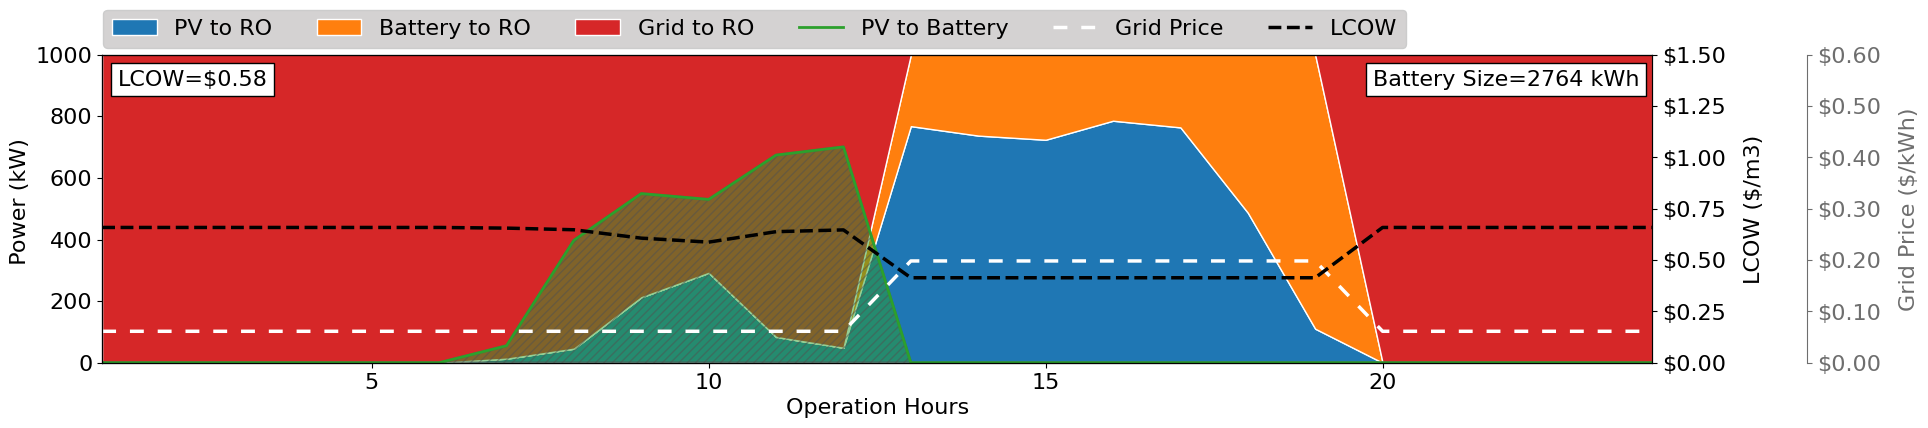

In [ ]:
from watertap_contrib.reflo.code_demos.util.visualize import *
create_long_plot(mp)

## Now let's optimize the battery

#### Unfix 
* Battery Nameplate Power
* Battery Nameplate Energy

In [ ]:
mp_optimized = optimize_multiperiod_pv_battery_model(surrogate=PV_surrogate)
results = solver.solve(mp_optimized)
print_results(mp_optimized)

2024-03-12 15:02:41 [WARNING] idaes.apps.grid_integration.multiperiod.multiperiod: model_data_kwargs argument is provided, so the flowsheet options are different for different time instances. In this case, the multiperiod model is returned without initialization.
2024-03-12 15:02:41 [INFO] idaes.apps.grid_integration.multiperiod.multiperiod: Constructing flowsheet model for time index 0
2024-03-12 15:02:41 [INFO] idaes.apps.grid_integration.multiperiod.multiperiod: Constructing flowsheet model for time index 1
2024-03-12 15:02:41 [INFO] idaes.apps.grid_integration.multiperiod.multiperiod: Constructing flowsheet model for time index 2
2024-03-12 15:02:41 [INFO] idaes.apps.grid_integration.multiperiod.multiperiod: Constructing flowsheet model for time index 3
2024-03-12 15:02:41 [INFO] idaes.apps.grid_integration.multiperiod.multiperiod: Constructing flowsheet model for time index 4
2024-03-12 15:02:41 [INFO] idaes.apps.grid_integration.multiperiod.multiperiod: Constructing flowsheet mod

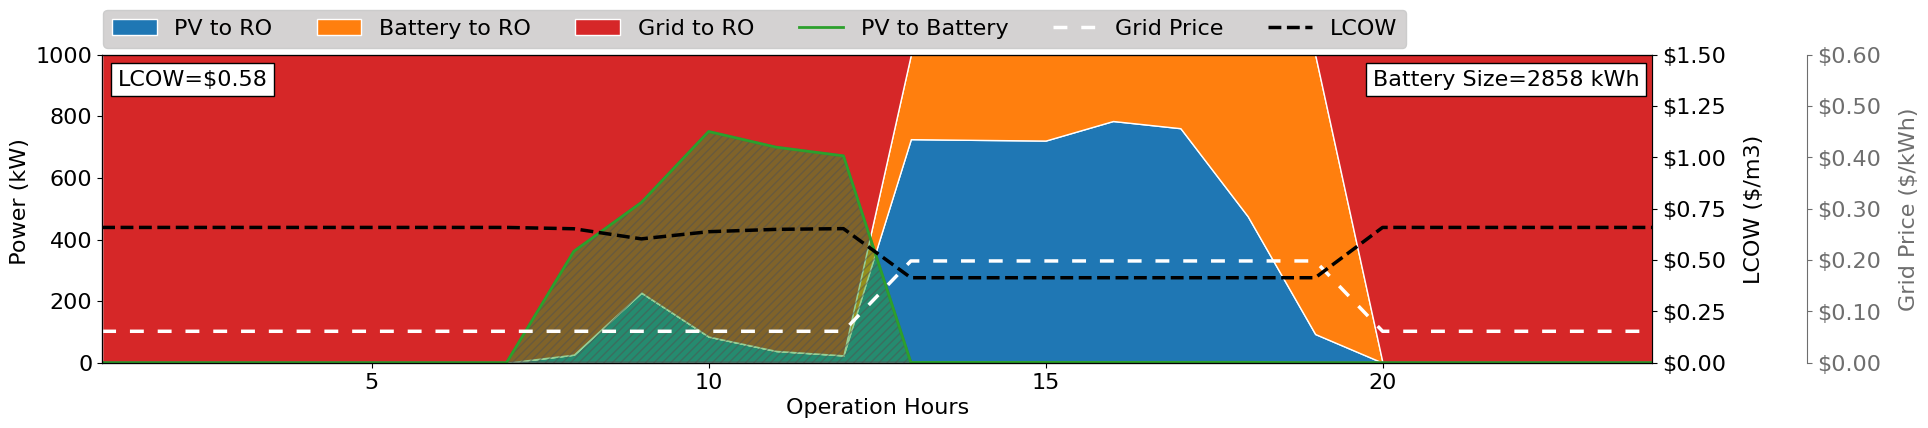

In [ ]:
create_plot(mp_optimized)

### We can also run this simulation over longer timescales

In [ ]:
mp_week = create_multiperiod_pv_battery_model(n_time_points=24*7, surrogate=PV_surrogate)
results = solver.solve(mp_week)
print_results(mp_week)

2024-03-12 15:02:41 [INFO] idaes.init.fs.battery: Battery initialization status optimal - Optimal Solution Found.


2024-03-12 15:02:42 [WARNING] idaes.apps.grid_integration.multiperiod.multiperiod: model_data_kwargs argument is provided, so the flowsheet options are different for different time instances. In this case, the multiperiod model is returned without initialization.
2024-03-12 15:02:42 [INFO] idaes.apps.grid_integration.multiperiod.multiperiod: Constructing flowsheet model for time index 0
2024-03-12 15:02:42 [INFO] idaes.apps.grid_integration.multiperiod.multiperiod: Constructing flowsheet model for time index 1
2024-03-12 15:02:42 [INFO] idaes.apps.grid_integration.multiperiod.multiperiod: Constructing flowsheet model for time index 2
2024-03-12 15:02:42 [INFO] idaes.apps.grid_integration.multiperiod.multiperiod: Constructing flowsheet model for time index 3
2024-03-12 15:02:42 [INFO] idaes.apps.grid_integration.multiperiod.multiperiod: Constructing flowsheet model for time index 4
2024-03-12 15:02:42 [INFO] idaes.apps.grid_integration.multiperiod.multiperiod: Constructing flowsheet mod

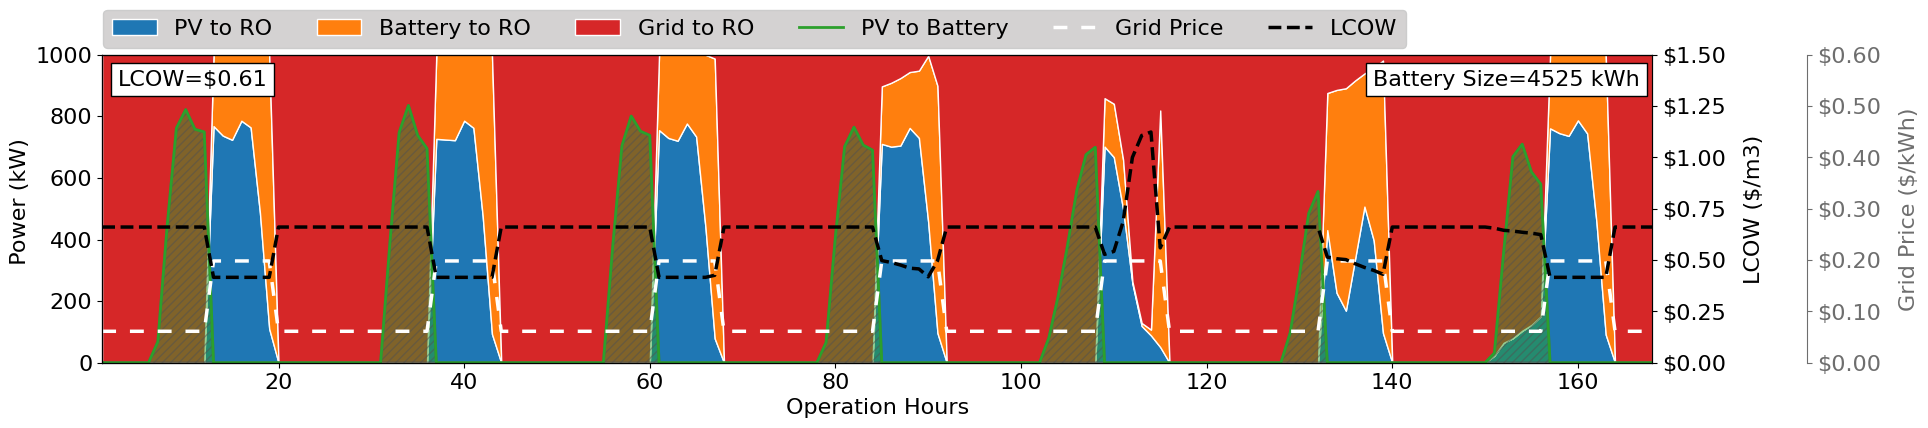

In [ ]:
create_long_plot(mp_week)